# Putting it all together

We now demonstrate all of Oloren ChemEngine's uncertainty features by training a production-level model and error model on the BACE dataset from DeepChem datasets.

In [1]:
import olorenchemengine as oce
import pandas as pd
import numpy as np

## Creating the dataset

We will train the model on 90% of the data and leave 10% for testing.

In [2]:
data = pd.read_csv(oce.download_public_file("MoleculeNet/load_bace_regression.csv"))[["smiles", "pIC50"]]

# Use smaller dataset for speed, remove this line for full dataset
data = data.sample(100)

bace_dataset = oce.BaseDataset(data=data.to_csv(), structure_col = "smiles", property_col = "pIC50")
splitter = oce.RandomSplit(split_proportions=[0.9,0,0.1])
bace_dataset = splitter.transform(bace_dataset)
oce.save(bace_dataset, "bace_dataset.oce")

## Training the production-level model

Production-level models can be produced by running ```fit_cv```, which in addition to fitting the whole model, fits the error model via cross validation.

100%|██████████| 18/18 [00:00<00:00, 2065.20it/s]


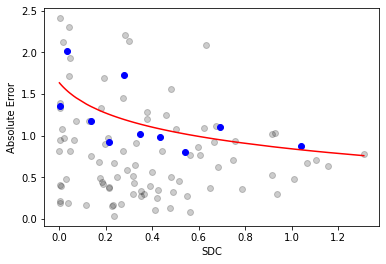

In [3]:
# Note this will take approx. 10 minutes to run
bace_dataset = oce.load("bace_dataset.oce")

model = oce.RandomForestModel(oce.OlorenCheckpoint("default")) 
# or for example model = oce.ZWK_XGBoostModel(oce.OlorenCheckpoint("default"))
# which is often more accurate but much slower to train

# windows needs to be smaller then the size of the validation dataset - 1
model.fit_cv(bace_dataset.train_dataset[0], bace_dataset.train_dataset[1], error_model = oce.SDC(windows=5))
oce.save(model, "bace_model.oce")

## Visualizing results

We visualize the probable output range for each test molecule (80% confidence interval) and the true output for each test molecule. For the ones plotted, each of the predicted values are within the error margin.

100%|██████████| 10/10 [00:00<00:00, 1791.37it/s]


,predicted,ci,vis
0,0.812739,0.941445,<olorenchemengine.visualizations.visualization...
1,0.797666,1.329300,<olorenchemengine.visualizations.visualization...
2,-0.286950,1.521771,<olorenchemengine.visualizations.visualization...
3,0.764217,0.895281,<olorenchemengine.visualizations.visualization...
4,-0.663500,1.273033,<olorenchemengine.visualizations.visualization...
5,0.465746,1.088760,<olorenchemengine.visualizations.visualization...
6,-0.804692,0.952951,<olorenchemengine.visualizations.visualization...
7,-0.293586,1.300911,<olorenchemengine.visualizations.visualization...
8,0.322176,1.064097,<olorenchemengine.visualizations.visualization...
9,0.241663,0.842276,<olorenchemengine.visualizations.visualization...


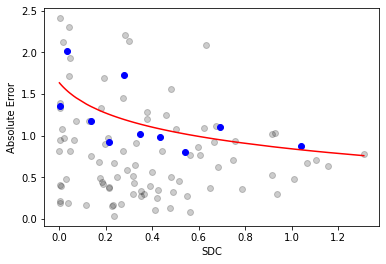

In [4]:
model = oce.load("bace_model.oce")
bace_dataset = oce.load("bace_dataset.oce")

results_df = model.predict(bace_dataset.test_dataset[0], return_ci=True, return_vis=True)
results_df

### Ground truth output

In [8]:
list(bace_dataset.test_dataset[1])[5]

0.1879141461033834

### Predicted output and error margin

Ways to improve the CI of this include (1) making better models, (2) tuning 
error model parameters, and (3) getting more training data

In [14]:
results_df["vis"][0].render_ipynb()